In [25]:
import sys
!{sys.executable} -m pip install shap joblib numpy==1.26.4

  Obtaining dependency information for numpy==1.26.4 from https://files.pythonhosted.org/packages/3f/6b/5610004206cf7f8e7ad91c5a85a8c71b2f2f8051a0c0c4d5916b76d6cbb2/numpy-1.26.4-cp311-cp311-win_amd64.whl.metadata
     ---------------------------------------- 0.0/61.0 kB ? eta -:--:--
     ---------------------------------------- 61.0/61.0 kB 1.1 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of numba to determine which version is compatible with other requirements. This could take a while.
  Obtaining dependency information for numba>=0.54 from https://files.pythonhosted.org/packages/5b/82/9d425c2f20d9f0a37f7cb955945a553a00fa06a2b025856c3550227c5543/numba-0.62.1-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for llvmlite<0.46,>=0.45.0dev0 from https://files.pythonhosted.org/packages/a4/56/4c0d503fe03bac820ecdeb14590cf9a248e120f483bcd5c009f2534f23f0/llvmlite-0.45.1-cp311-cp311-win_amd64.whl.metadata
   ---------------------------------------- 0.0/15.8 

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.0 requires FuzzyTM>=0.4.0, which is not installed.
tables 3.8.0 requires blosc2~=2.0.0, which is not installed.
tables 3.8.0 requires cython>=0.29.21, which is not installed.


In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import joblib
import shap
import os


In [ ]:
SCRIPT_DIR = Path().resolve()

data_path = SCRIPT_DIR.parent/'data'/'processed_data.csv'

output_path = SCRIPT_DIR.parent /'results'
output_path.parent.mkdir(parents=True, exist_ok=True)


saved_pipe_path = SCRIPT_DIR.parent /'saved_models'/"best_pipeline.joblib"
encoder_path = SCRIPT_DIR.parent /'saved_models'/"label_encoder.joblib"

try:
    df = pd.read_csv(data_path)
    print(f"Data loaded successfully!")
    loaded_pipe = joblib.load(saved_pipe_path) 
    loaded_encoder = joblib.load(encoder_path)  
except FileNotFoundError:
    print(f"Error: One or more files were not found. Please check paths.")

# Define X, y

df['MouseID_cleaned'] = df['MouseID'].str.split("_").str[0]

X = df.drop(['class',"MouseID", "Genotype", "Treatment", 'Behavior',
                    'MouseID_cleaned'], axis=1)
y_raw = df['class']
# y = LabelEncoder().fit_transform(y_raw)
# Recreate encoded labels from raw ones
y_encoded = loaded_encoder.transform(y_raw)

# Then decode back when you need original labels
y_original = loaded_encoder.inverse_transform(y_encoded)
y = pd.Series(y_encoded)

Data loaded successfully!


In [ ]:

def explain_svm_with_shap(pipeline, X, sample_size=400, background_size=50, nsamples=200, output_path):
  
  
    if not isinstance(X, pd.DataFrame):
        X = pd.DataFrame(X, columns=[f"feature_{i}" for i in range(X.shape[1])])


    X_sample = X.sample(min(sample_size, len(X)), random_state=42).reset_index(drop=True)

  
    def predict_fn(data):
        df = pd.DataFrame(data, columns=X.columns)
        return pipeline.predict_proba(df)

    X_background = shap.sample(X_sample, background_size, random_state=42)


    explainer = shap.KernelExplainer(predict_fn, X_background, link="logit")


    print(f"Computing SHAP values on {len(X_sample)} samples...")
    shap_values = explainer.shap_values(X_sample, nsamples=nsamples)

    print("\n SHAP Summary Plots Generated:")
    shap.summary_plot(shap_values, X_sample, plot_type="bar", show=False)
    plt.title("SHAP Feature Importance (Bar Summary)")
    fig_path = os.path.join(output_path, "SHAP1.png")
    plt.savefig(fig_path)
    plt.show()

    shap.summary_plot(shap_values, X_sample, show=False)
    plt.title("SHAP Summary Plot")
    fig_path = os.path.join(output_path, "SHAP2.png")
    plt.savefig(fig_path)
    plt.show()

    return shap_values

In [31]:
pca = loaded_pipe.named_steps['pca']
pca_loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f"PC{i+1}" for i in range(pca.n_components_)],
    index=getattr(loaded_pipe.named_steps['scaler'], 'feature_names_in_', X.columns)
)

Computing SHAP values on 400 samples...


  0%|          | 0/400 [00:00<?, ?it/s]


 SHAP Summary Plots Generated:


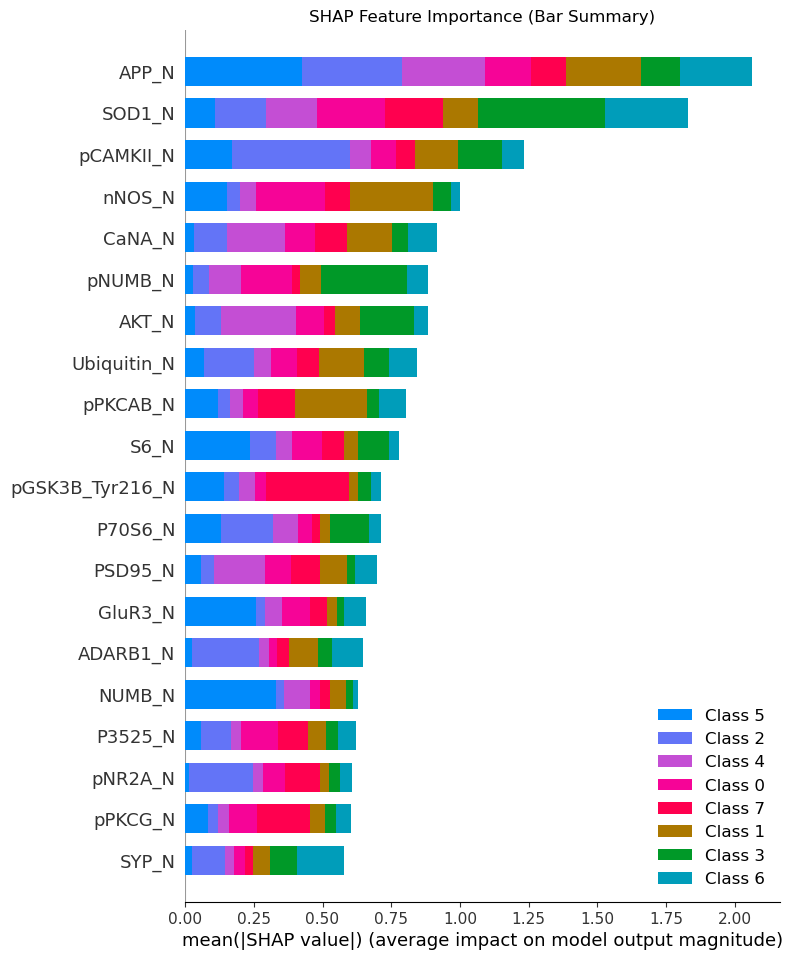

c:\Users\aparn\anaconda3\Lib\site-packages\shap\plots\_beeswarm.py:1150: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
c:\Users\aparn\anaconda3\Lib\site-packages\shap\plots\_beeswarm.py:758: UserWarning: The figure layout has changed to tight
  plt.tight_layout(pad=0, w_pad=0, h_pad=0.0)


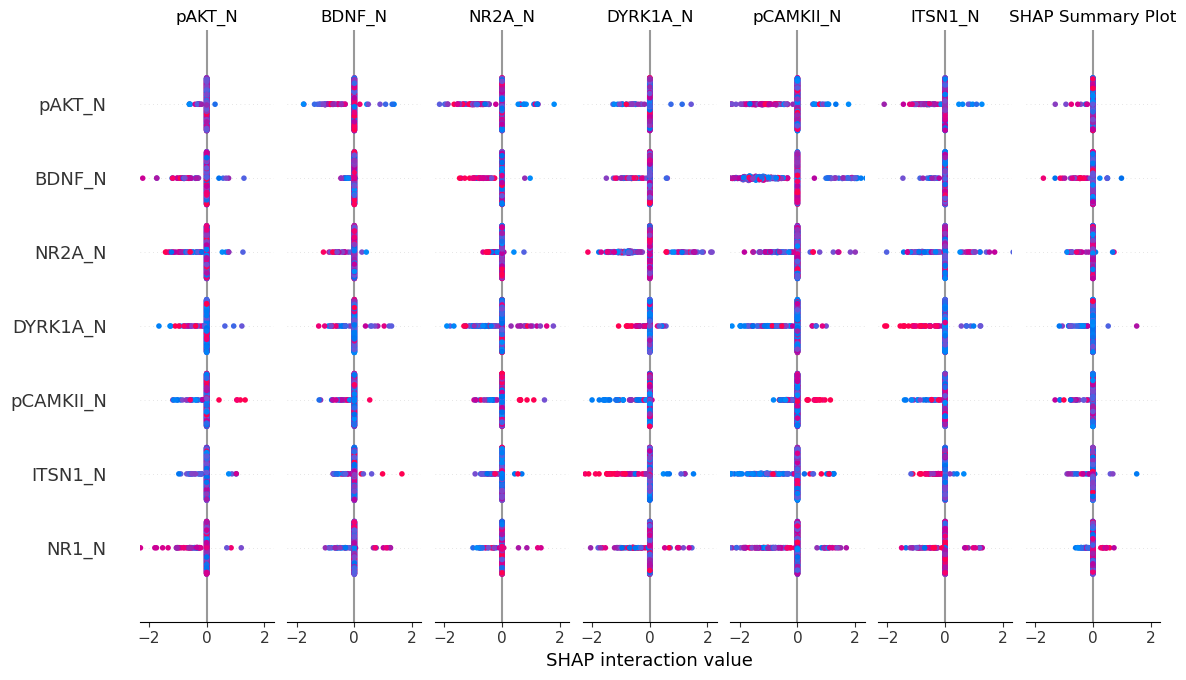

In [29]:
shap_values = explain_svm_with_shap(loaded_pipe, X)

In [ ]:
mean_abs_shap = np.abs(shap_values).mean(axis=(0, 2))  
top_idx = np.argsort(mean_abs_shap)[-5:][::-1]
feature_names = getattr(loaded_pipe.named_steps['scaler'], 'feature_names_in_', X.columns)
top_features = [feature_names[int(i)] for i in top_idx]
print("Top 5 SHAP features:", top_features)

Top 3 SHAP features: ['APP_N', 'SOD1_N', 'pCAMKII_N', 'nNOS_N', 'CaNA_N']


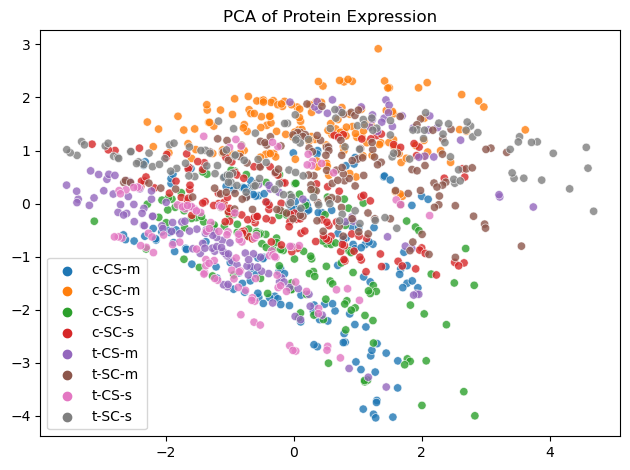

In [ ]:
from sklearn.decomposition import PCA
import seaborn as sns
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=y_original, alpha=0.8)
plt.title("PCA of Protein Expression")
plt.tight_layout()
fig_path = os.path.join(output_path, "PCA.png")
plt.savefig(fig_path)
plt.show()


In [42]:
from umap import UMAP

umap = UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
X_umap = umap.fit_transform(X)

plt.figure(figsize=(6,5))
sns.scatterplot(x=X_umap[:,0], y=X_umap[:,1], hue=y_original, palette="viridis", s=30)
plt.title("UMAP of Protein Expression")
plt.tight_layout()
plt.show()

ModuleNotFoundError: No module named 'umap'

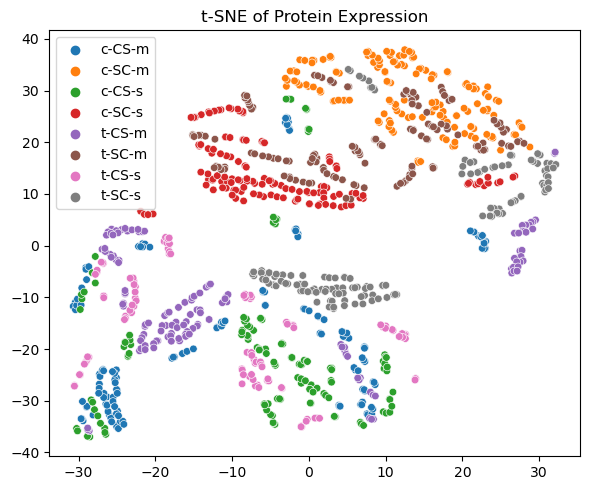

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

tsne = TSNE(n_components=2, random_state=42, perplexity=42)
X_tsne = tsne.fit_transform(X)

plt.figure(figsize=(6,5))
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=y_original, s=30)
plt.title("t-SNE of Protein Expression")
plt.tight_layout()
fig_path = os.path.join(output_path, "t_SNE.png")
plt.savefig(fig_path)
plt.show()
plt.show()

In [58]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt



def plot_pdp_for_multiclass(loaded_pipe, X, top_features, targets, encoder=None):
   
    n_feats = len(top_features)
    n_targets = len(targets)

    # Set up subplot grid 
    fig, axs = plt.subplots(n_feats, n_targets, figsize=(3*n_targets, 3*n_feats), squeeze=False)

    for i, feat in enumerate(top_features):
        for j, target in enumerate(targets):
            ax = axs[i, j]
            try:
                PartialDependenceDisplay.from_estimator(
                    loaded_pipe,
                    X,
                    [feat],
                    target=target,
                    ax=ax
                )

                # Title handling
                class_label = encoder.classes_[target] if encoder else f"Class {target}"
                ax.set_title(f"{feat} — {class_label}", fontsize=9)
            except Exception as e:
                ax.axis('off')
                ax.text(0.5, 0.5, f"Error: {e}", ha='center', va='center', fontsize=8)

    plt.tight_layout()
    plt.grid(True)
    plt.show()


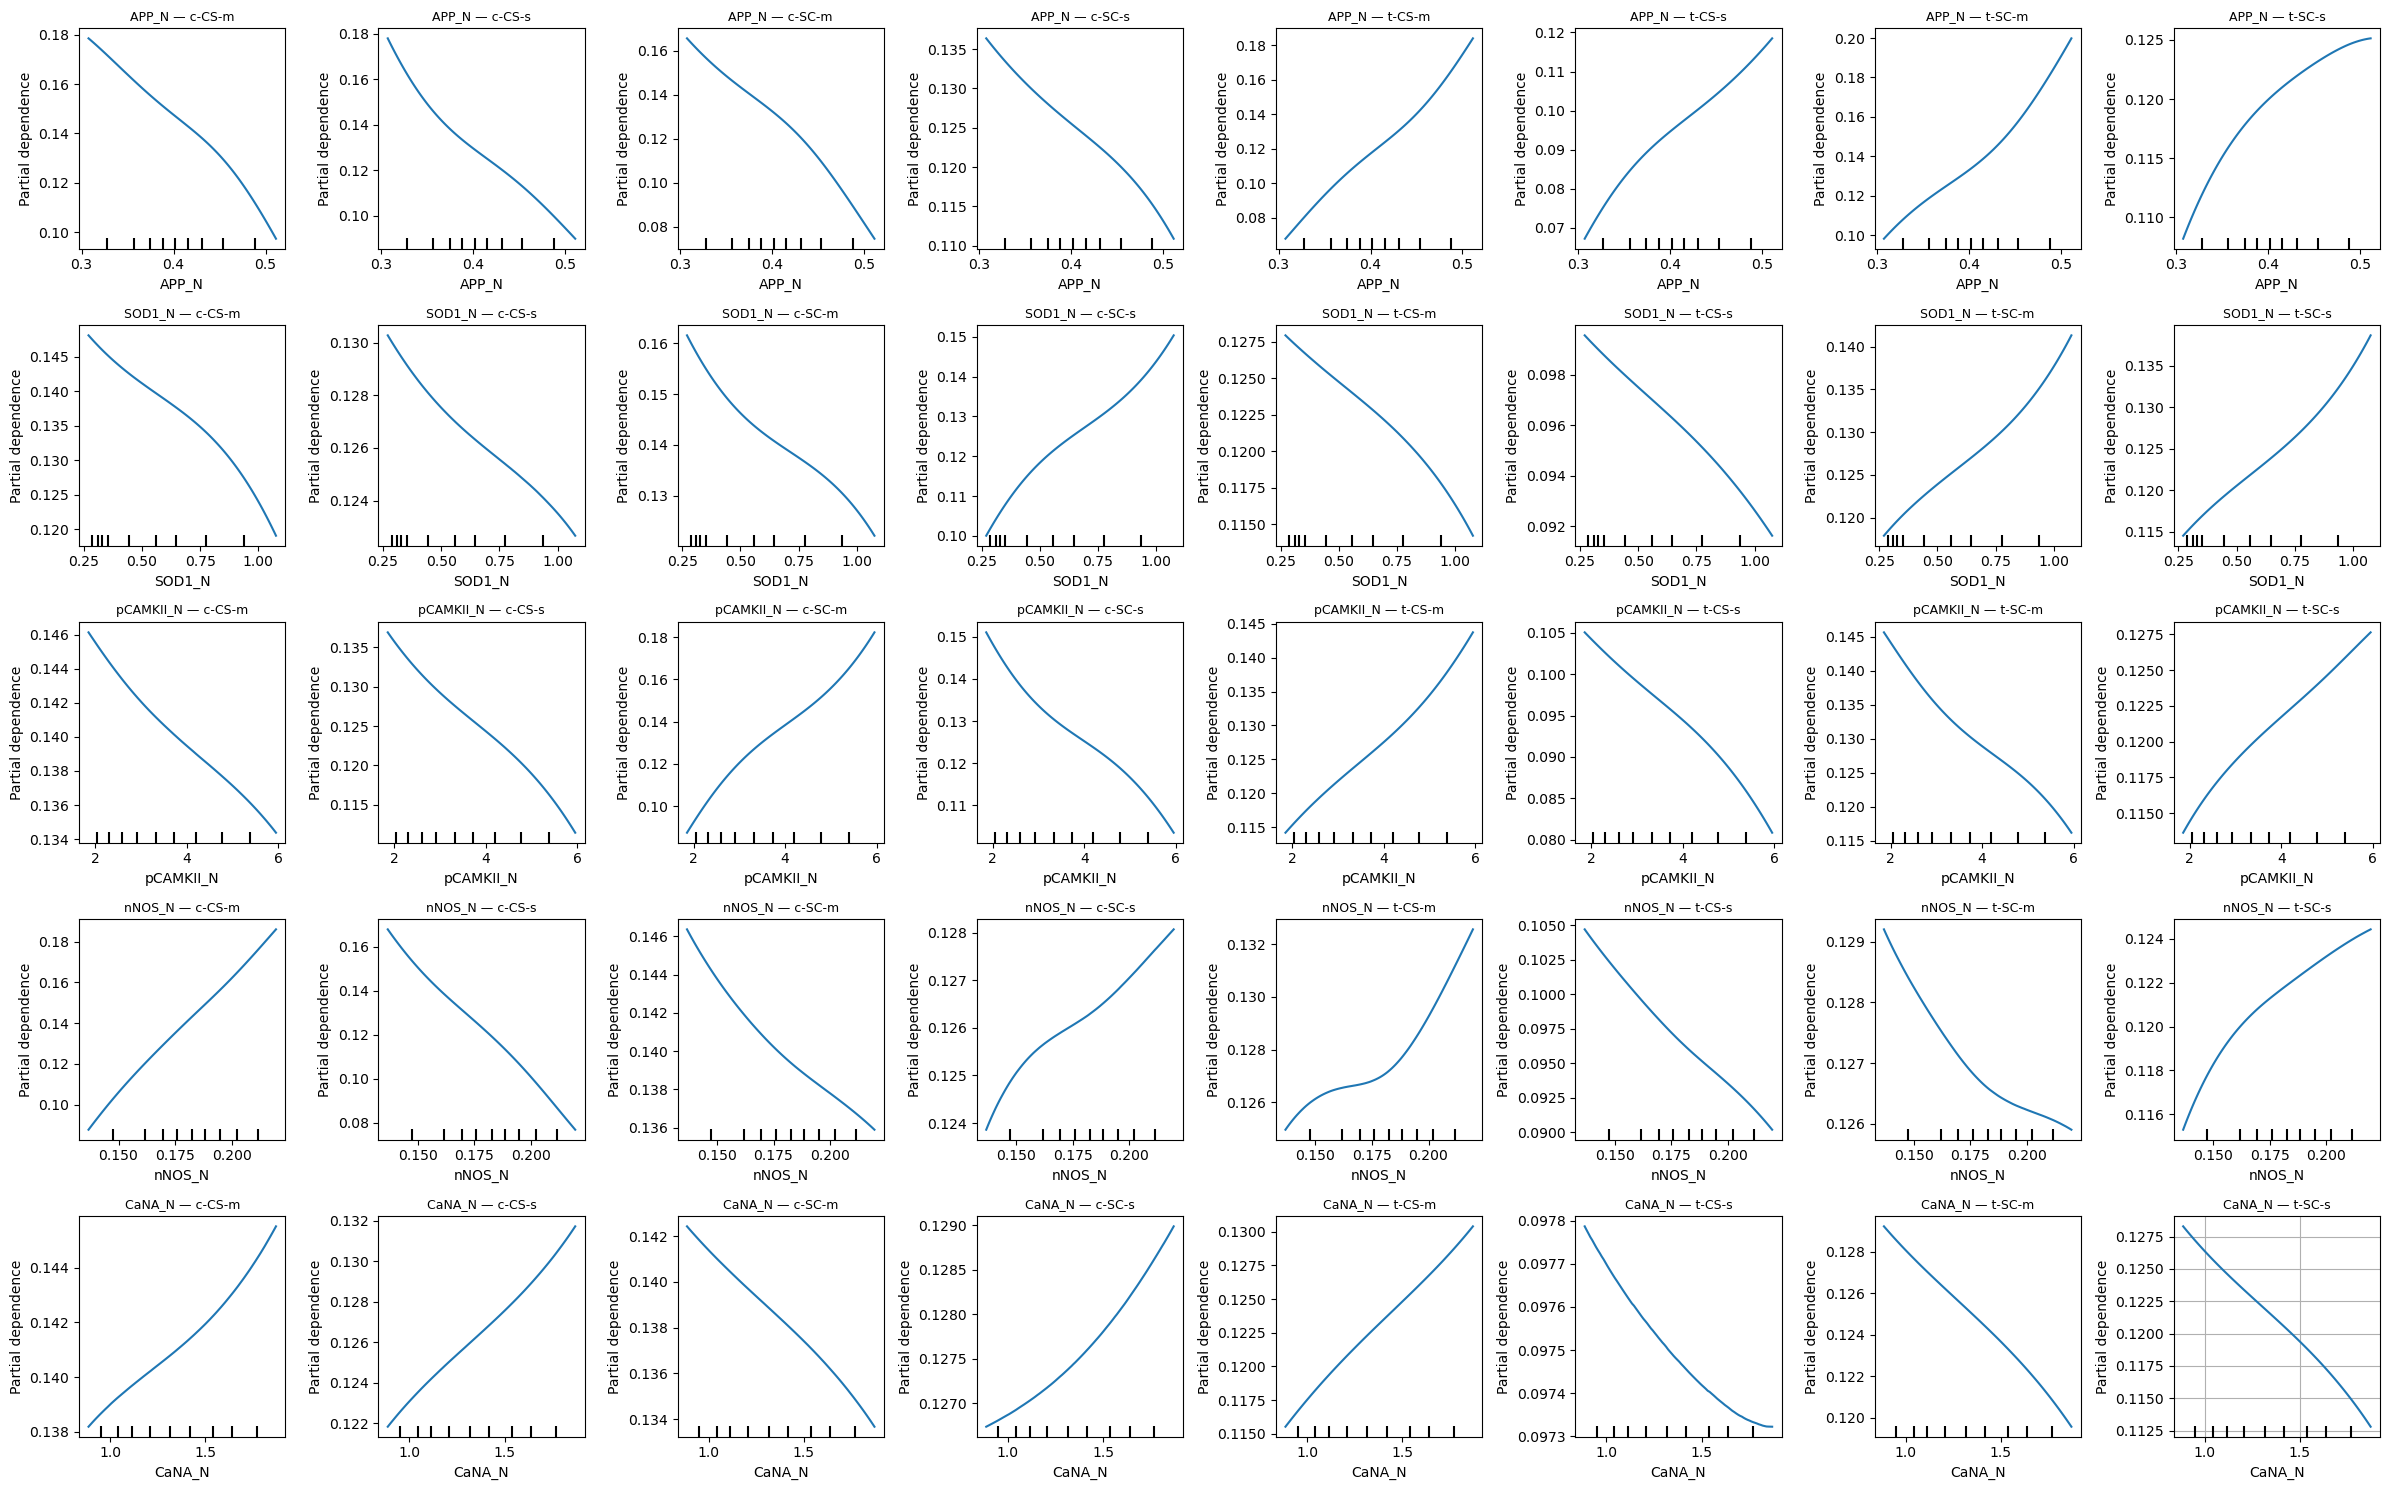

In [59]:
targets = [0,1,2,3,4,5,6,7]
plot_pdp_for_multiclass(loaded_pipe, X, top_features, targets, encoder=loaded_encoder)

## Exploratory Data Analysis

In [60]:
# Selecting the relavant columns

cols = top_features + ['class','MouseID', 'Genotype', 'Behavior', 'Treatment']

# Making a df of the selected columns

df_imp = df[cols]

In [61]:
def percent_change(target, control, indicator, df ):

  diff_list = []

  for col in top_features:

    group_medians =  df.groupby(indicator)[col].median()

    median_difference = (group_medians.loc[target] - group_medians.loc[control])*100/group_medians.loc[control]

    row = [col, group_medians.loc[target], group_medians.loc[control], median_difference, abs(median_difference)]

    diff_list.append(row)

  diff = pd.DataFrame(diff_list, columns=['protein', 'target_median', 'control_median', 'difference', 'abs_diff'])

  diff = diff.sort_values(by='abs_diff', ascending=False, inplace=False)

  return diff

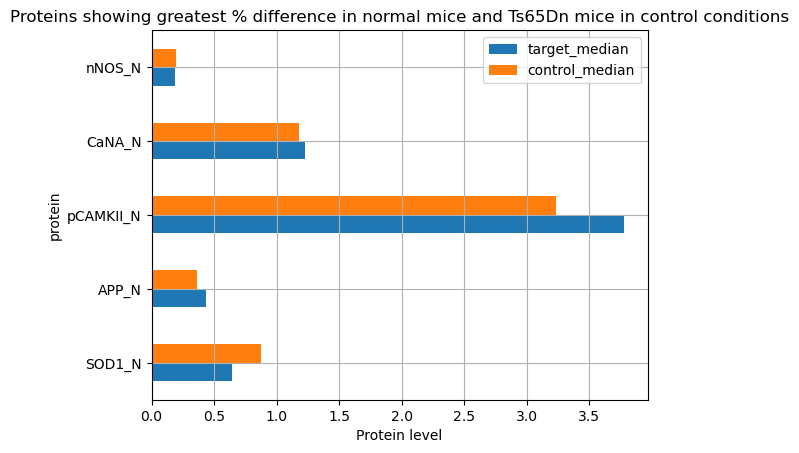

In [63]:
# Selecting the parameters

df1 = df_imp[(df_imp['Behavior']=='S/C') & (df_imp['Treatment']=='Saline')]

target = 'Ts65Dn'

control = 'Control'

indicator = 'Genotype'

# Applying the select_proteins method

df_res_1 = percent_change(target, control, indicator, df1 )[['protein','target_median','control_median']].set_index('protein').head(5)

# plotting

df_res_1.plot(kind='barh')

plt.xlabel('Protein level')

plt.title('Proteins showing greatest % difference in normal mice and Ts65Dn mice in control conditions')
plt.grid(True)
plt.show()


#### Hypothesis testing 1: Is the difference of DYK1A in normal and ts65Dn mice significant?

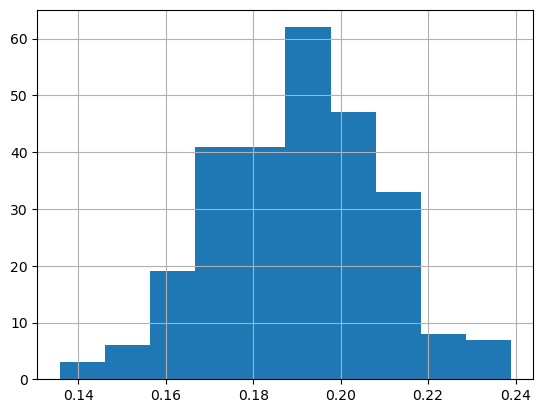

In [64]:
# checking the normality of the protein distribution
df = df_imp[df_imp['class'].isin(['c-SC-s','t-SC-s'])]

df['nNOS_N'].hist()

plt.show()

In [66]:
# p-test
from scipy import stats
# H0: There is no significant difference in the medians of 'DYRK1A_N' levels in normal and ts65DN MICE IN CONTROL CONDITIONS
# H1: There is A significant difference in the medians of 'DYRK1A_N' levels in normal and ts65DN MICE IN CONTROL CONDITIONS

# TEST: t-TEST

df1 = df[df['class']=='c-SC-s']['nNOS_N']
df2 = df[df['class']=='t-SC-s']['nNOS_N']

t_statistic, p_value = stats.ttest_ind(df1, df2)

print("T-statistic:", t_statistic)
print("P-value:", p_value)


# Interpret the result
alpha = 0.05

if p_value < alpha:
    print(f"Reject the null hypothesis: The mean 'DYRK1A level is signicantly different between control and ts65Dn mice.")
else:
    print(f"Fail to reject the null hypothesis: The mean 'DYRK1A level is NOT signicantly different between control and ts65Dn mice.")


T-statistic: 2.309442503732967
P-value: 0.021688234847185323
Reject the null hypothesis: The mean 'DYRK1A level is signicantly different between control and ts65Dn mice.


#### Chart 1: The levels of which proteins differ the most in normal and Ts65Dn mice in control conditions?

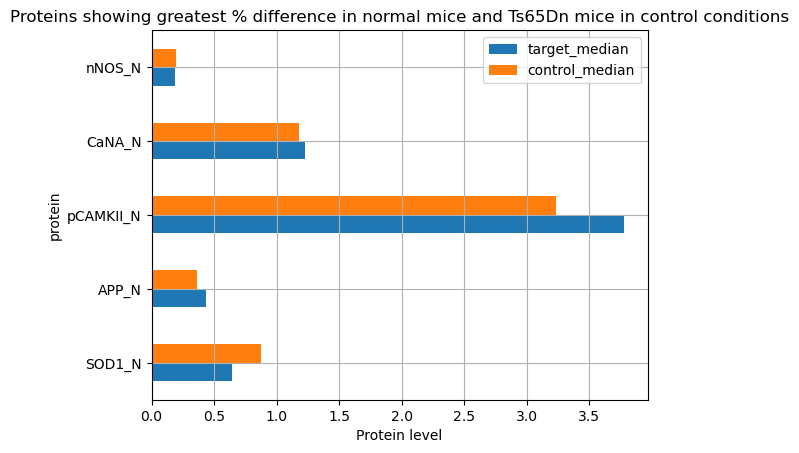

In [67]:
# Selecting the parameters

df1 = df_imp[(df_imp['Behavior']=='S/C') & (df_imp['Treatment']=='Saline')]

target = 'Ts65Dn'

control = 'Control'

indicator = 'Genotype'

# Applying the select_proteins method

df_res_1 = percent_change(target, control, indicator, df1 )[['protein','target_median','control_median']].set_index('protein').head(5)

# plotting

df_res_1.plot(kind='barh')

plt.xlabel('Protein level')

plt.title('Proteins showing greatest % difference in normal mice and Ts65Dn mice in control conditions')
plt.grid(True)
plt.show()


#### Chart 2: Which proteins change the most when a normal rat shows learning behavior?

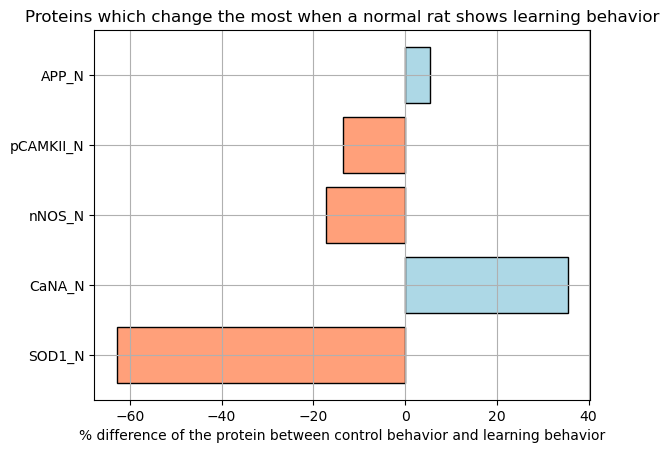

In [68]:
# selecting the df

df1 = df_imp[(df_imp['Genotype']=='Control') & (df_imp['Treatment']=='Saline')]


# Applying the function
df_temp = percent_change('C/S', 'S/C', 'Behavior', df1).head(10)

colors = [
    'lightblue' if idx > 0
    else 'lightsalmon' if idx < 0
    else 'gray'
    for idx in df_temp['difference']
  ]

# plotting

plt.barh(width=df_temp['difference'], y=df_temp['protein'], color=colors, edgecolor='k',)

plt.xlabel('% difference of the protein between control behavior and learning behavior')
plt.title('Proteins which change the most when a normal rat shows learning behavior')
plt.grid(True)
plt.show()

Insights:

When a normal rat shows learning behavior, the protein pPKCAB_N increases by almost 80% whereas 'SOD1_N' decreases by about 60%.

Chart 3 : What is the distribution of 'SOD1_N' in learning and control behaviors of normal mice? How about in Ts65DN mice?

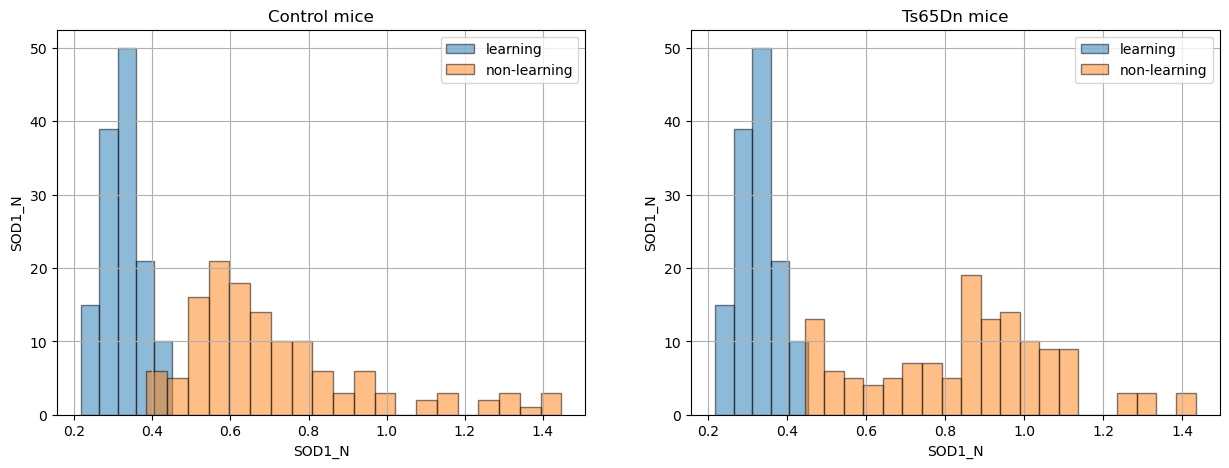

In [70]:

# DRAW HISTOGRAM OF BOTH

#separate normal and diseased rats

fig, axs = plt.subplots(1,2, figsize=(15,5))

df_imp[(df_imp['Behavior'] =='C/S') & (df_imp['Genotype'] == 'Control')&(df_imp['Treatment']=='Saline')]['SOD1_N'].hist(bins=5, edgecolor='k', alpha=0.5, label = 'learning', ax=axs[0] )
df_imp[(df_imp['Behavior'] == 'S/C') & (df_imp['Genotype'] == 'Ts65Dn')&(df_imp['Treatment']=='Saline')]['SOD1_N'].hist(bins=20, edgecolor='k', alpha=0.5, label = 'non-learning', ax=axs[0])
axs[0].legend(loc='upper right')
axs[0].set_title('Control mice')
axs[0].set_xlabel('SOD1_N')
axs[0].set_ylabel('SOD1_N')


df_imp[(df_imp['Behavior'] =='C/S') & (df_imp['Genotype'] == 'Control')&(df_imp['Treatment']=='Saline')]['SOD1_N'].hist(bins=5, edgecolor='k', alpha=0.5, label = 'learning', ax=axs[1] )
df_imp[(df_imp['Behavior'] == 'S/C') & (df_imp['Genotype'] == 'Control')&(df_imp['Treatment']=='Saline')]['SOD1_N'].hist(bins=20, edgecolor='k', alpha=0.5, label = 'non-learning', ax=axs[1])
axs[1].set_title('Ts65Dn mice')
axs[1].set_xlabel('SOD1_N')
axs[1].set_ylabel('SOD1_N')

plt.legend(loc='upper right')
plt.show()

Insights:

1. The mean and spread of *'SOD1_N'*   protein is significantly different between  learning and non-learning behaviors in both control and Ts65dN mice.

2. While learning, the protein expression rangesfrom $0.0-0.1$ in both normal and autistic mice whereas in non-learning behaviour, it ranges from $0.1 - 0.7$ in normal mice and $0.1-1.0$ in down Syndrome mice.

3. This protein can be used to differentitate clearly between learning and non-learning behaviours in both normal and Ts65dN mice.

#### Chart 4: Which proteins does Memeantine effect the most in Ts65Dn mice when stimulated to learn?

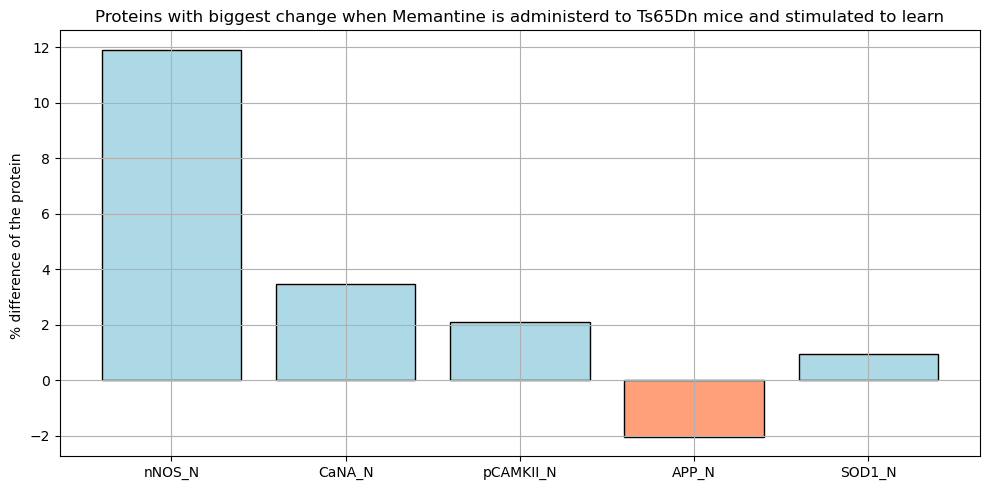

In [71]:
# Effect of memantine in learning environment for autistic rats

# selecting the df

df1 = df_imp[(df_imp['Genotype']=='Ts65Dn') & (df_imp['Behavior']=='C/S')]


# Applying the function
df_temp = percent_change('Memantine', 'Saline', 'Treatment', df1).head(10)

colors = [
    'lightblue' if idx > 0
    else 'lightsalmon' if idx < 0
    else 'gray'
    for idx in df_temp['difference']
  ]

# plotting

fig, axs = plt.subplots(1,1, figsize=(10,5))

#axs[0].barh(width=df_temp['difference'], y=df_temp['protein'], color=colors, edgecolor='k',)

axs.bar(height=df_temp['difference'], x=df_temp['protein'], color=colors, edgecolor='k')

plt.ylabel('% difference of the protein ')
plt.title('Proteins with biggest change when Memantine is administerd to Ts65Dn mice and stimulated to learn')

plt.tight_layout()
plt.grid(True)
plt.show()




Insights:

From the figure, we see that Memantine increases pP7056_N by about 45%, icreases DYRK1A by about 30% and decreases S6_N by about 25% .

#### Chart -5: What are the ranges of these proteins in normal mice when administerd with Saline and stimulated to learn?

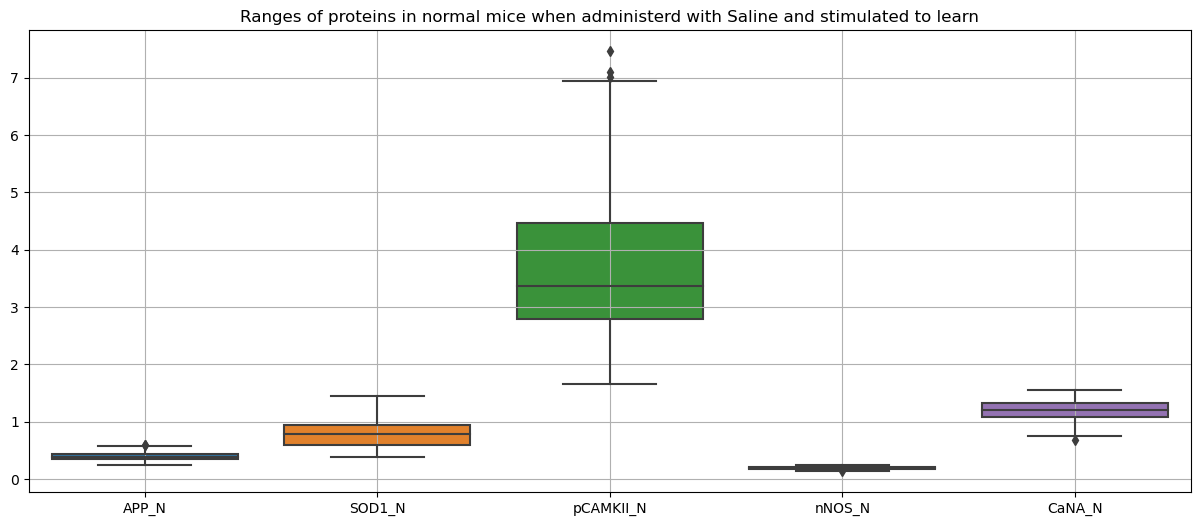

In [72]:
proteins = df_temp.head(10)['protein'].to_list()

df1 = df_imp[(df_imp['Behavior'] == 'C/S') & (df_imp['Treatment'] == 'Saline')]

df1 = df[proteins]


plt.figure(figsize=(15, 6))

sns.boxplot(df)
plt.title('Ranges of proteins in normal mice when administerd with Saline and stimulated to learn')
plt.grid(True)


#### Chart 6: Heatmap of the proteins

<Axes: >

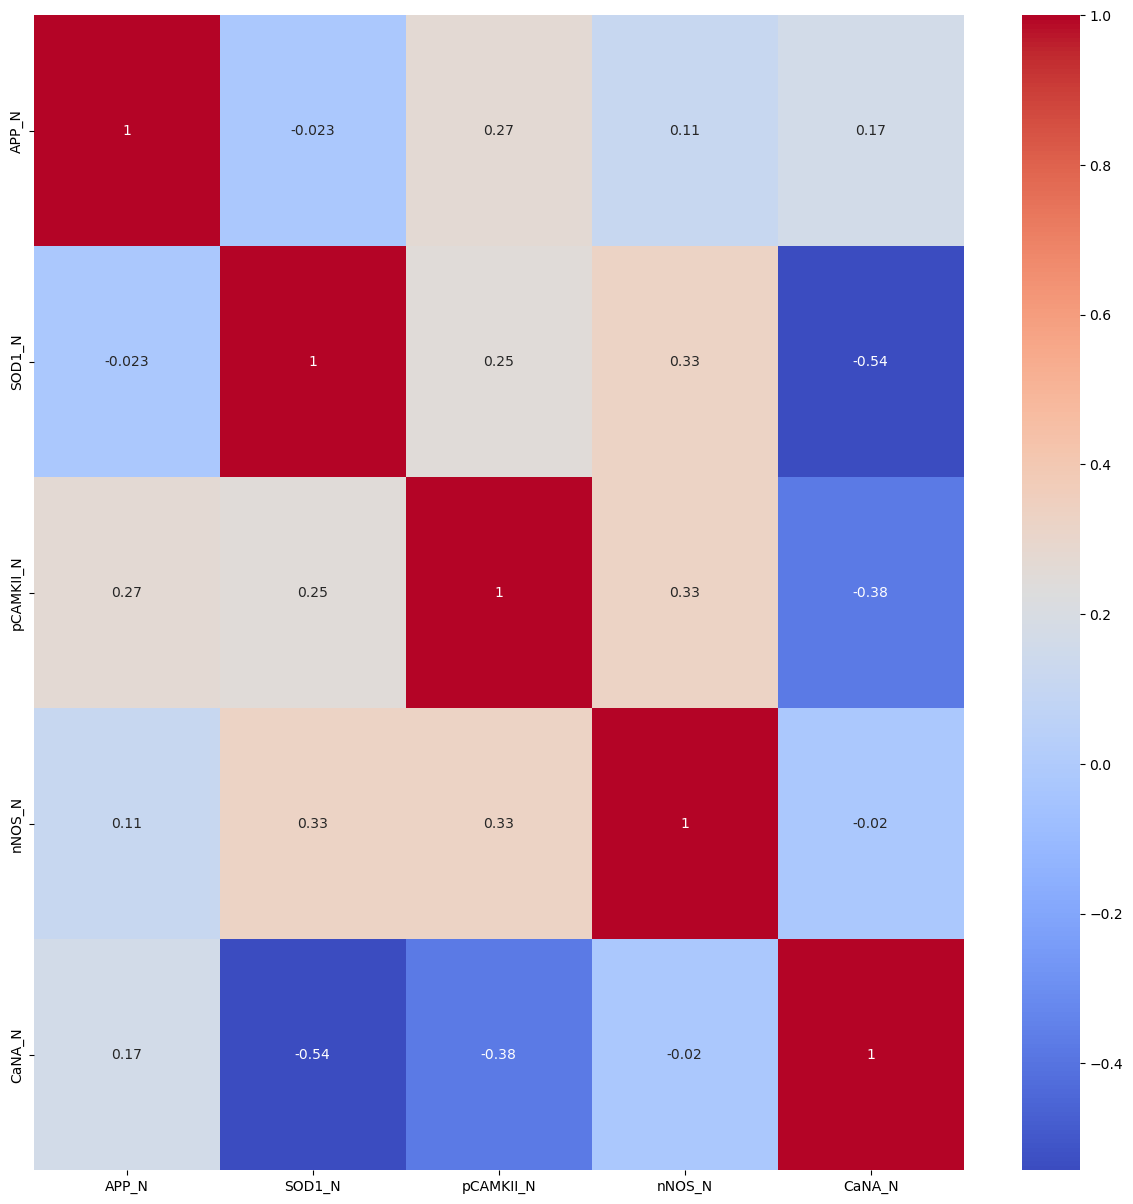

In [74]:
plt.figure(figsize=(15, 15))
sns.heatmap(df_imp[top_features].corr(), annot=True, cmap='coolwarm')

Insights:

From the heatmap, we see there there are some strong correlations betwee proteins such as DYRK1A_N and ITSN1_N with correlation coefficient of $0.9$, pNR2B_N and pNR2A_N with correlation coefficient of $0.7$ etc.

We will next plot scatter plots of  DYRK1A_N and ITSN1_N to see whether the relationship is linear or of higher power.

#### Chart- 7 : How do DYRK1A_N and ITSN1_N change with each other? How about CaNA_N and SOD1_N?

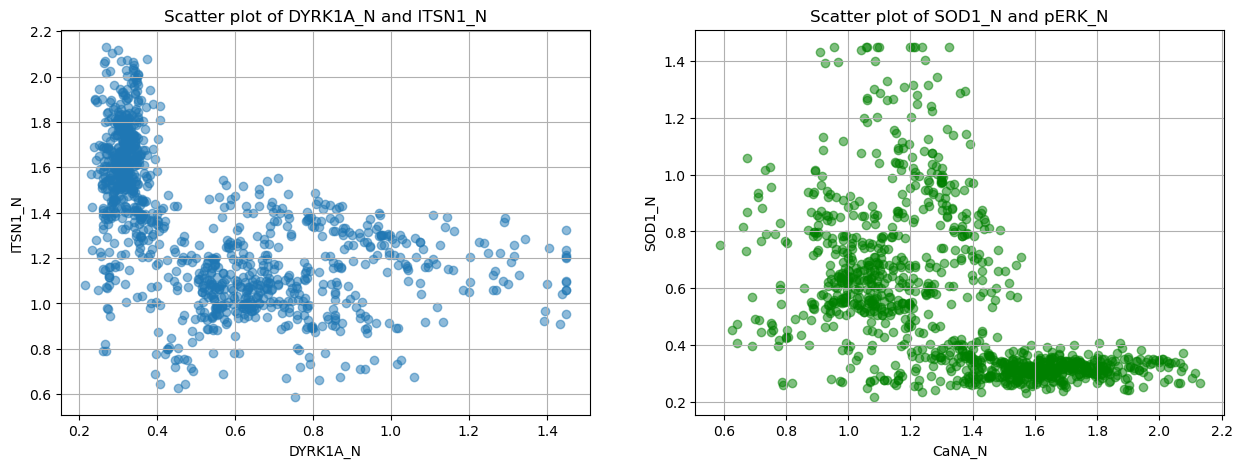

In [76]:
fig, axs = plt.subplots(1,2, figsize=(15,5))

axs[0].scatter(df_imp['SOD1_N'], df_imp['CaNA_N'], alpha = 0.5)
axs[0].set_xlabel('DYRK1A_N')
axs[0].set_ylabel('ITSN1_N')
axs[0].set_title('Scatter plot of DYRK1A_N and ITSN1_N')
axs[0].grid(True)


axs[1].scatter(df_imp['CaNA_N'], df_imp['SOD1_N'], alpha=0.5, color = 'green')
axs[1].set_xlabel('CaNA_N')
axs[1].set_ylabel('SOD1_N')
axs[1].set_title('Scatter plot of SOD1_N and pERK_N')
axs[1].grid(True)

plt.show()

Insights:

We observe  pERK_N and SOD1_N show interesting behavior. The readings are divided into two groups of low CaNA_N and low SOD1_N.

We will next see which classes do low CaNA_N and low SOD1_N represent.

#### Chart -8 : Which classes do low CaNA_N and low SOD1_N represent?

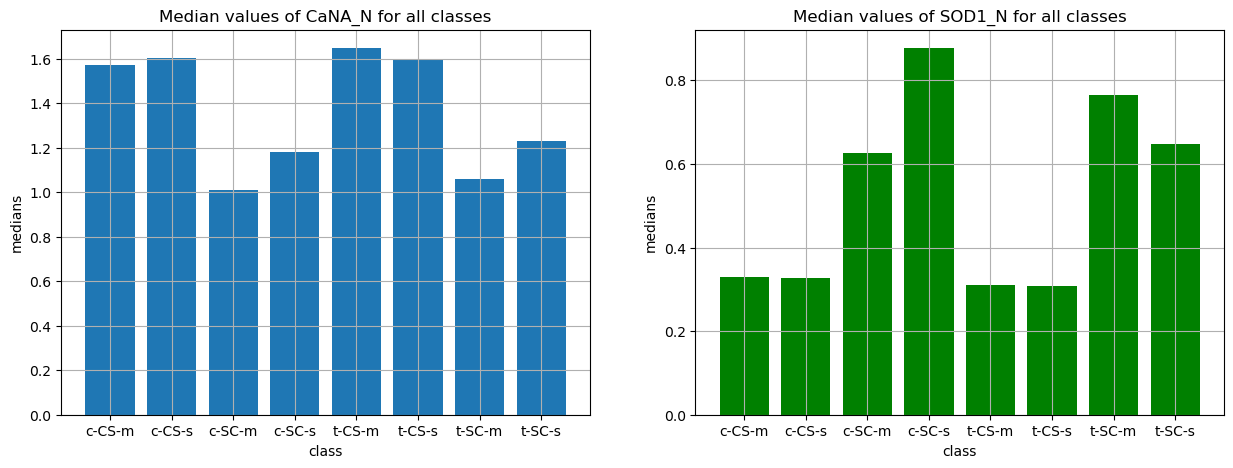

In [77]:
medians = df_imp.groupby('class')[['CaNA_N', 'SOD1_N']].median()

fig, axs = plt.subplots(1,2, figsize=(15,5))

axs[0].bar(x = medians.index, height = medians['CaNA_N'])
axs[0].set_xlabel('class')
axs[0].set_ylabel('medians')
axs[0].set_title('Median values of CaNA_N for all classes')
axs[0].grid(True)


axs[1].bar(x = medians.index, height = medians['SOD1_N'], color ='green')
axs[1].set_xlabel('class')
axs[1].set_ylabel('medians')
axs[1].set_title('Median values of SOD1_N for all classes')
axs[1].grid(True)

plt.show()

Insights:

From the above chart, it is clear that higher CaNA_N represents learning behavior whereas higher SOD1_N represents non-learning or control behavior.